In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
#Uses gpu if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(0)
batch_size = 128

#Downloads datasets
image_size = (32, 32)
transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(), transforms.Normalize(mean=[0.4914, 0.482, 0.4465], std=[0.247, 0.2435, 0.2616])])
dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform) #Set download to true first time
class_names = dataset.classes

#Split for cross validation
test_size = len(dataset) // 6
train_size = len(dataset) - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#Creates DataLoaders for each set
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


100.0%


In [4]:
#Defines class for a residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, halving):
        super().__init__()

        #If halving is true, the feature size is cut in half and the out_channels is doubled
        out_channels = in_channels
        stride1 = 1
        stride2 = 1
        if halving:
            out_channels *= 2
            stride1 = 2

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1), \
                                        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)) if halving else None

    def forward(self, x):
        #Keeps activation from previous layer to add as residual later
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        #Normal convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        #Adds residual
        x += identity
        out = F.relu(x)
        return out


In [12]:
#Defines Convolutional Neural Network

class Resnet(nn.Module):
    def __init__(self,):
        super().__init__()

        #Residual/Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.reslayers = nn.ModuleList()

        #Sets size of network. Paper uses n = {3,5,7,9}, but starting with smallest at 3
        n = 9

        for _ in range(n-1):
            self.reslayers.append(ResidualBlock(in_channels=16, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=16, kernel_size=3, halving=True))

        for _ in range(n-1):
            self.reslayers.append(ResidualBlock(in_channels=32, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=32, kernel_size=3, halving=True))

        for _ in range(n):
            self.reslayers.append(ResidualBlock(in_channels=64, kernel_size=3, halving=False))

        self.pool2 = nn.AvgPool2d(kernel_size=8,stride=1)

        #Fully connected layers
        self.flatten = nn.Flatten()
        self.out = nn.Linear(in_features=64, out_features=10)


    def forward(self, x):
        #Residual/Convolutional layers with ReLU activation function
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        for reslayer in self.reslayers:
            x = reslayer(x)

        x = self.pool2(x)

        #Fully connected layer with ReLU activation
        x = self.flatten(x)
        out = F.relu(self.out(x))
        
        return out

In [ ]:
#Iterates through a training epoch while displaying performance metrics by batch
def train_epoch(network, optimizer, criterion):
    network.train(True)
    running_loss = 0.0
    running_accuracy = 0.0

    # Generate numpy arrays to save our training data and plot it
    save_every = 50
    batches = []
    losses = []
    accuracy = []
    batch_count_avg = 0

    for batch_index, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = network(inputs)
        num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += num_correct / batch_size

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        batch_count_avg += 1
        loss.backward()
        optimizer.step()

        if batch_index % save_every-1 == 0:
            avg_loss_across_batches = running_loss / batch_count_avg
            avg_acc_across_batches = (running_accuracy / batch_count_avg) * 100
            batches.append(batch_index)
            losses.append(avg_loss_across_batches)
            accuracy.append(avg_acc_across_batches)
            print('Batch{0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1, avg_loss_across_batches, avg_acc_across_batches))
            running_loss = 0
            running_accuracy = 0
            batch_count_avg = 0

    return batches, losses, accuracy

    

#Optional method to evaluate performance on validation data
def validate_epoch(network, criterion):
    network.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = network(inputs)
            num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += num_correct / batch_size

            loss = criterion(outputs, labels)
            running_loss += loss.item()


    avg_loss_across_batches = running_loss / len(testloader)
    avg_accuracy_across_batches = (running_accuracy / len(testloader)) * 100
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches, avg_accuracy_across_batches))
    print('*****************************************')
    print()

    return avg_loss_across_batches, avg_accuracy_across_batches
            

In [ ]:
def new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation):
    fig, ax = plt.subplots(4, 1, sharex=True)
    ax[0].clear()
    ax[0].plot(batches_training, losses_training, label='Training Loss', color='blue')
    ax[0].set_ylabel('Loss')
    ax[0].relim()
    ax[0].autoscale_view()

    ax[1].clear()
    ax[1].plot(batches_training, accuracies_training, label='Training Accuracies', color='blue')
    ax[1].set_ylabel('Accuracy')
    ax[1].relim()
    ax[1].autoscale_view()

    ax[2].clear()
    ax[2].plot(batches_validation, losses_validation, label='Validation Loss', color='blue')
    ax[2].set_ylabel('Loss')
    ax[2].relim()
    ax[2].autoscale_view()

    ax[3].clear()
    ax[3].plot(batches_validation, accuracies_validation, label='Validation Accuracies', color='blue')
    ax[3].set_ylabel('Accuracy')
    ax[3].relim()
    ax[3].autoscale_view()
    
    ax[3].set_xlabel('Batch Number')
    ax[0].set_title('Training and Validation Loss Over Time')

    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.pause(0.1)  # Adjust to control the update speed
    return fig

Epoch 1
Batch1, Loss: 2.510, Accuracy: 7.8%
Batch51, Loss: 2.102, Accuracy: 24.8%
Batch101, Loss: 1.867, Accuracy: 34.2%
Batch151, Loss: 1.748, Accuracy: 38.8%
Batch201, Loss: 1.629, Accuracy: 44.0%
Batch251, Loss: 1.570, Accuracy: 46.5%
Batch301, Loss: 1.495, Accuracy: 49.8%
Val Loss: 1.617, Val Accuracy: 43.8%
*****************************************



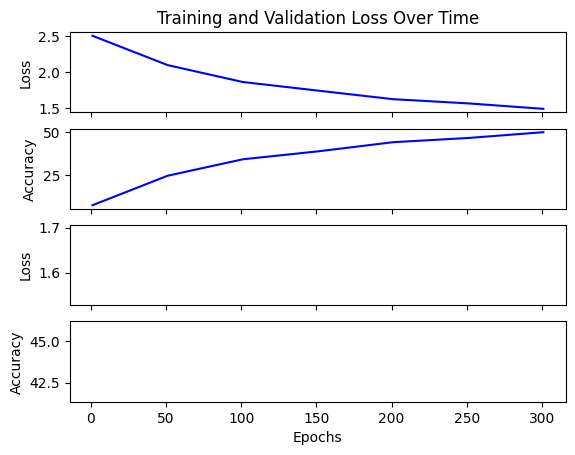

Epoch 2
Batch1, Loss: 1.476, Accuracy: 48.4%
Batch51, Loss: 1.437, Accuracy: 51.2%
Batch101, Loss: 1.402, Accuracy: 52.8%
Batch151, Loss: 1.400, Accuracy: 52.6%
Batch201, Loss: 1.359, Accuracy: 53.7%
Batch251, Loss: 1.336, Accuracy: 54.8%
Batch301, Loss: 1.330, Accuracy: 54.6%
Val Loss: 1.399, Val Accuracy: 52.5%
*****************************************



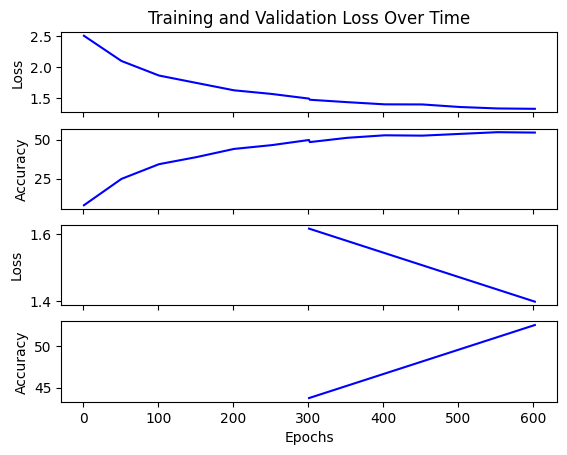

Epoch 3
Batch1, Loss: 1.257, Accuracy: 58.6%
Batch51, Loss: 1.212, Accuracy: 60.9%
Batch101, Loss: 1.119, Accuracy: 63.8%
Batch151, Loss: 1.120, Accuracy: 63.6%
Batch201, Loss: 1.103, Accuracy: 64.0%
Batch251, Loss: 1.045, Accuracy: 65.8%
Batch301, Loss: 1.019, Accuracy: 66.5%
Val Loss: 1.129, Val Accuracy: 61.9%
*****************************************



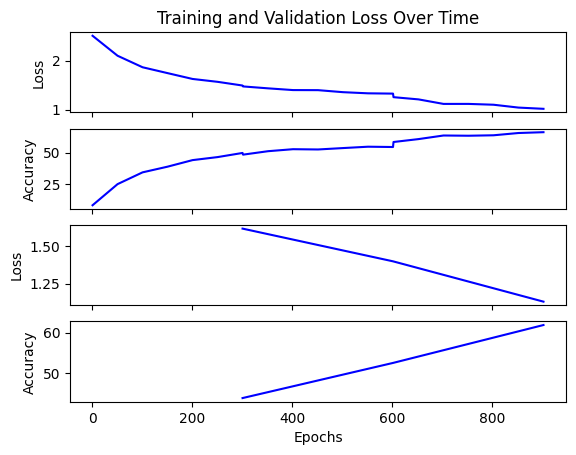

Epoch 4
Batch1, Loss: 0.920, Accuracy: 68.0%
Batch51, Loss: 0.974, Accuracy: 67.9%
Batch101, Loss: 0.955, Accuracy: 69.2%
Batch151, Loss: 0.924, Accuracy: 69.7%
Batch201, Loss: 0.940, Accuracy: 69.7%
Batch251, Loss: 0.911, Accuracy: 70.3%
Batch301, Loss: 0.902, Accuracy: 70.0%
Val Loss: 1.116, Val Accuracy: 63.2%
*****************************************



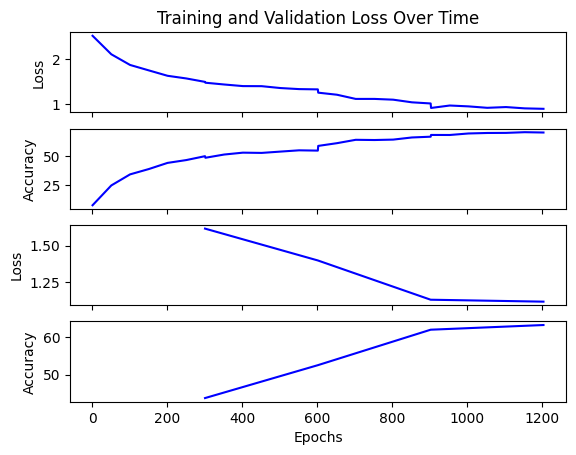

Epoch 5
Batch1, Loss: 0.711, Accuracy: 78.1%
Batch51, Loss: 0.859, Accuracy: 72.0%
Batch101, Loss: 0.813, Accuracy: 72.5%
Batch151, Loss: 0.836, Accuracy: 72.5%
Batch201, Loss: 0.858, Accuracy: 71.2%
Batch251, Loss: 0.834, Accuracy: 72.8%
Batch301, Loss: 0.828, Accuracy: 72.8%
Val Loss: 0.998, Val Accuracy: 66.5%
*****************************************



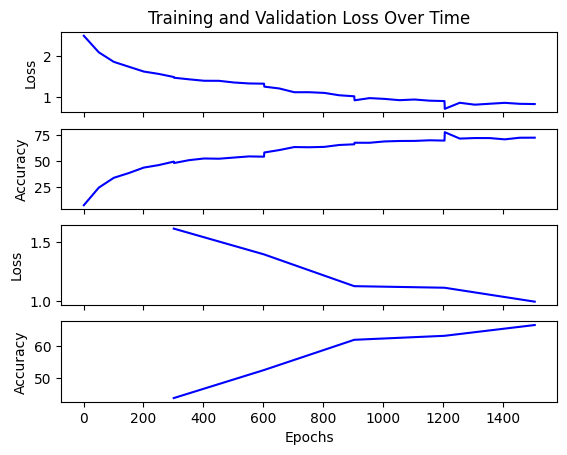

Epoch 6
Batch1, Loss: 0.771, Accuracy: 75.8%
Batch51, Loss: 0.750, Accuracy: 75.0%
Batch101, Loss: 0.738, Accuracy: 75.9%
Batch151, Loss: 0.734, Accuracy: 76.0%
Batch201, Loss: 0.767, Accuracy: 74.4%
Batch251, Loss: 0.785, Accuracy: 73.8%
Batch301, Loss: 0.786, Accuracy: 74.3%
Val Loss: 0.927, Val Accuracy: 69.3%
*****************************************



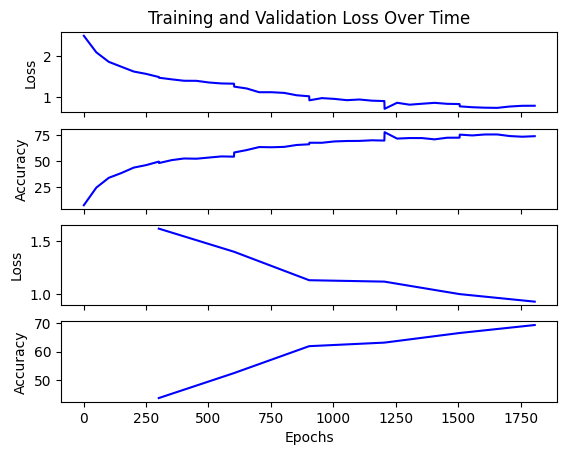

Epoch 7
Batch1, Loss: 0.667, Accuracy: 78.1%
Batch51, Loss: 0.715, Accuracy: 76.2%
Batch101, Loss: 0.694, Accuracy: 77.0%
Batch151, Loss: 0.681, Accuracy: 77.1%
Batch201, Loss: 0.728, Accuracy: 76.4%
Batch251, Loss: 0.709, Accuracy: 76.0%
Batch301, Loss: 0.679, Accuracy: 77.7%
Val Loss: 0.939, Val Accuracy: 69.9%
*****************************************



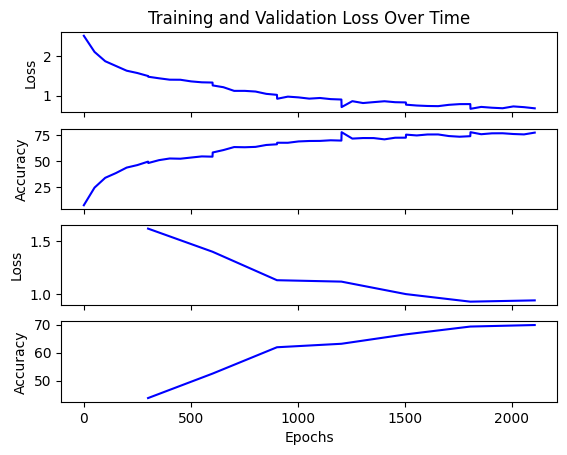

Epoch 8
Batch1, Loss: 0.589, Accuracy: 78.9%
Batch51, Loss: 0.635, Accuracy: 78.7%
Batch101, Loss: 0.632, Accuracy: 79.3%
Batch151, Loss: 0.651, Accuracy: 77.9%
Batch201, Loss: 0.654, Accuracy: 78.6%
Batch251, Loss: 0.663, Accuracy: 77.8%
Batch301, Loss: 0.650, Accuracy: 77.9%
Val Loss: 0.918, Val Accuracy: 70.2%
*****************************************



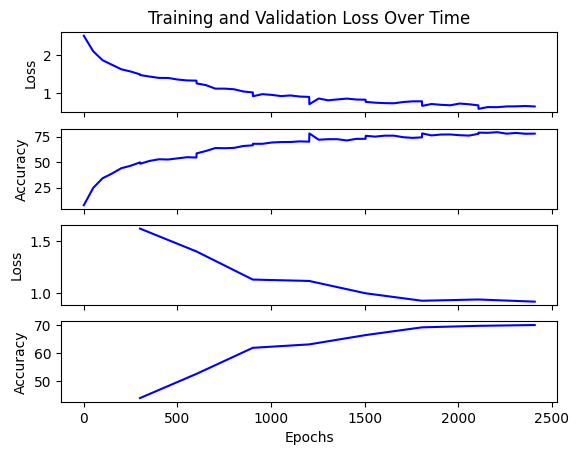

Epoch 9
Batch1, Loss: 0.625, Accuracy: 76.6%
Batch51, Loss: 0.578, Accuracy: 80.5%
Batch101, Loss: 0.590, Accuracy: 80.5%
Batch151, Loss: 0.587, Accuracy: 80.6%
Batch201, Loss: 0.598, Accuracy: 79.8%
Batch251, Loss: 0.622, Accuracy: 78.8%
Batch301, Loss: 0.627, Accuracy: 79.2%
Val Loss: 0.849, Val Accuracy: 71.7%
*****************************************



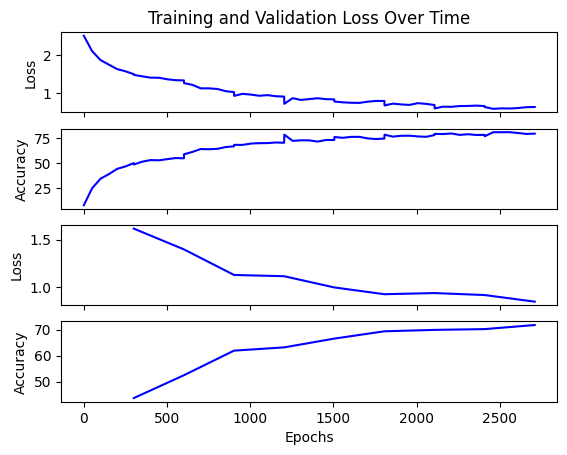

Epoch 10
Batch1, Loss: 0.539, Accuracy: 79.7%
Batch51, Loss: 0.540, Accuracy: 81.8%
Batch101, Loss: 0.573, Accuracy: 80.0%
Batch151, Loss: 0.551, Accuracy: 81.3%
Batch201, Loss: 0.555, Accuracy: 81.6%
Batch251, Loss: 0.582, Accuracy: 80.7%
Batch301, Loss: 0.559, Accuracy: 80.8%
Val Loss: 1.165, Val Accuracy: 65.3%
*****************************************



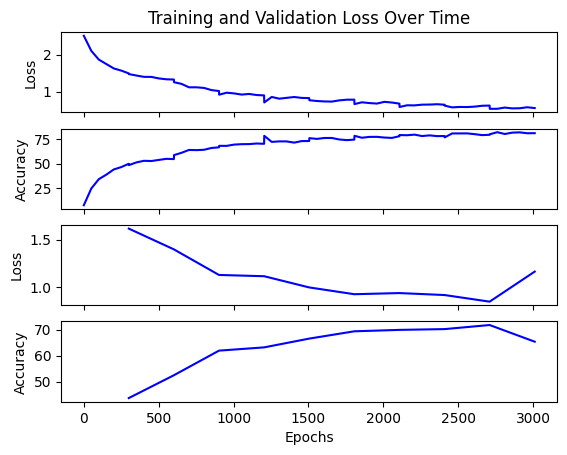

Epoch 11
Batch1, Loss: 0.473, Accuracy: 84.4%
Batch51, Loss: 0.488, Accuracy: 83.2%
Batch101, Loss: 0.500, Accuracy: 82.8%
Batch151, Loss: 0.525, Accuracy: 81.7%
Batch201, Loss: 0.546, Accuracy: 81.0%
Batch251, Loss: 0.559, Accuracy: 80.9%
Batch301, Loss: 0.547, Accuracy: 81.2%
Val Loss: 0.828, Val Accuracy: 73.9%
*****************************************



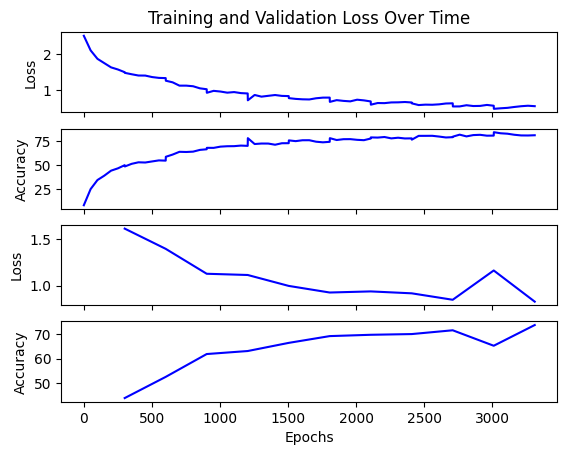

Epoch 12
Batch1, Loss: 0.480, Accuracy: 84.4%
Batch51, Loss: 0.470, Accuracy: 83.8%
Batch101, Loss: 0.476, Accuracy: 83.6%
Batch151, Loss: 0.481, Accuracy: 83.2%
Batch201, Loss: 0.486, Accuracy: 83.2%
Batch251, Loss: 0.529, Accuracy: 81.6%
Batch301, Loss: 0.501, Accuracy: 82.9%
Val Loss: 0.911, Val Accuracy: 72.0%
*****************************************



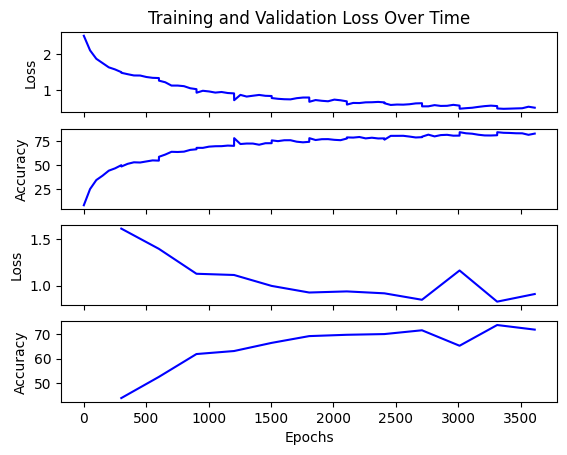

Epoch 13
Batch1, Loss: 0.415, Accuracy: 84.4%
Batch51, Loss: 0.446, Accuracy: 84.4%
Batch101, Loss: 0.439, Accuracy: 84.7%
Batch151, Loss: 0.449, Accuracy: 84.2%
Batch201, Loss: 0.502, Accuracy: 82.7%
Batch251, Loss: 0.470, Accuracy: 83.7%
Batch301, Loss: 0.483, Accuracy: 83.2%
Val Loss: 0.805, Val Accuracy: 73.4%
*****************************************



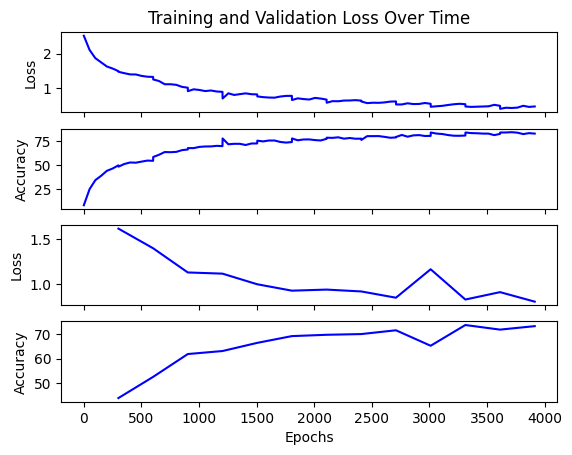

Epoch 14
Batch1, Loss: 0.414, Accuracy: 85.9%
Batch51, Loss: 0.410, Accuracy: 85.7%
Batch101, Loss: 0.431, Accuracy: 84.8%
Batch151, Loss: 0.447, Accuracy: 84.0%
Batch201, Loss: 0.403, Accuracy: 85.9%
Batch251, Loss: 0.417, Accuracy: 85.1%
Batch301, Loss: 0.472, Accuracy: 83.6%
Val Loss: 0.907, Val Accuracy: 72.4%
*****************************************



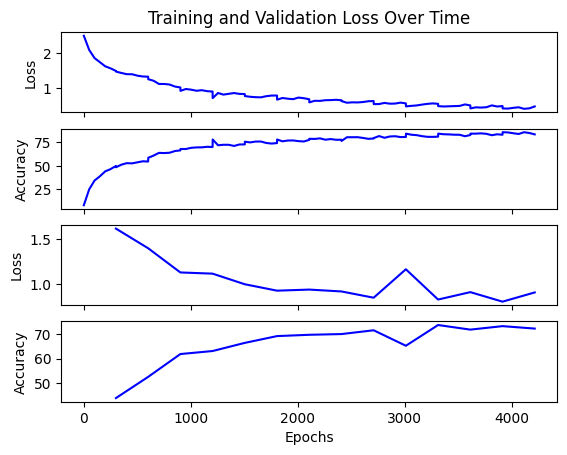

Epoch 15
Batch1, Loss: 0.399, Accuracy: 84.4%
Batch51, Loss: 0.393, Accuracy: 86.0%
Batch101, Loss: 0.379, Accuracy: 86.0%
Batch151, Loss: 0.411, Accuracy: 84.9%
Batch201, Loss: 0.423, Accuracy: 84.8%
Batch251, Loss: 0.425, Accuracy: 84.8%
Batch301, Loss: 0.418, Accuracy: 85.0%
Val Loss: 0.855, Val Accuracy: 71.8%
*****************************************



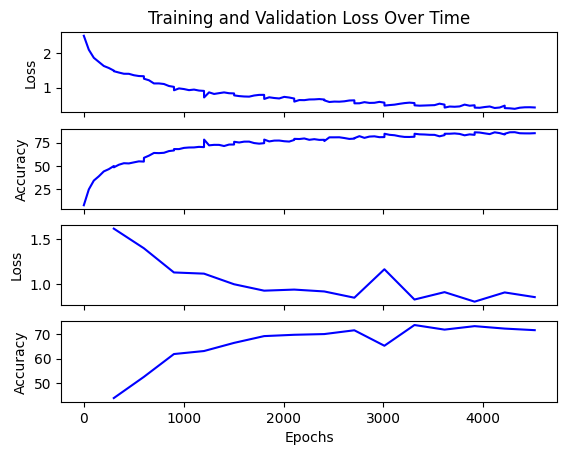

Epoch 16
Batch1, Loss: 0.268, Accuracy: 89.8%
Batch51, Loss: 0.359, Accuracy: 86.8%
Batch101, Loss: 0.359, Accuracy: 86.7%
Batch151, Loss: 0.375, Accuracy: 86.0%
Batch201, Loss: 0.400, Accuracy: 85.3%
Batch251, Loss: 0.439, Accuracy: 84.3%
Batch301, Loss: 0.419, Accuracy: 85.0%
Val Loss: 0.984, Val Accuracy: 70.7%
*****************************************



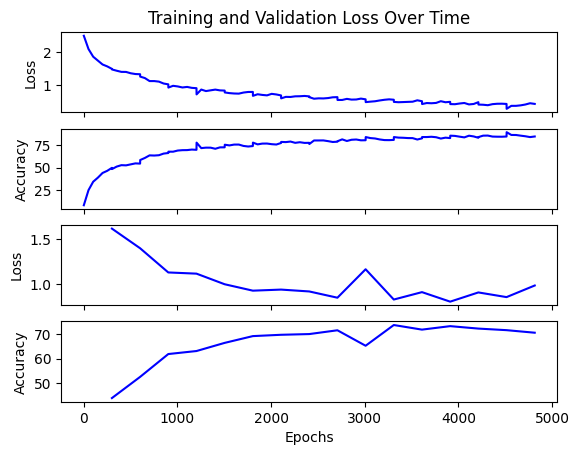

Epoch 17
Batch1, Loss: 0.504, Accuracy: 83.6%
Batch51, Loss: 0.362, Accuracy: 86.2%
Batch101, Loss: 0.353, Accuracy: 87.0%
Batch151, Loss: 0.397, Accuracy: 85.3%
Batch201, Loss: 0.382, Accuracy: 85.8%
Batch251, Loss: 0.402, Accuracy: 85.6%
Batch301, Loss: 0.404, Accuracy: 85.2%
Val Loss: 0.955, Val Accuracy: 73.4%
*****************************************



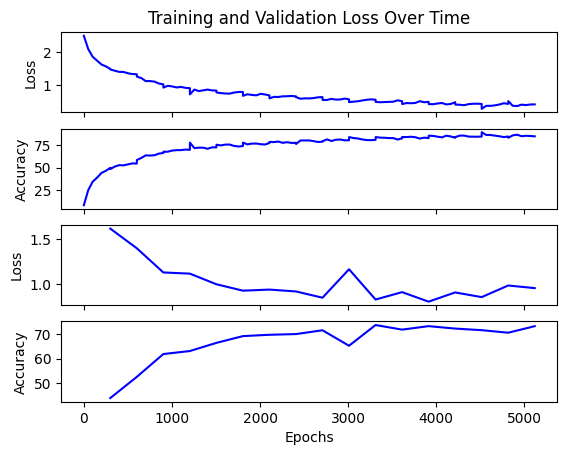

Epoch 18
Batch1, Loss: 0.434, Accuracy: 82.8%
Batch51, Loss: 0.342, Accuracy: 87.3%
Batch101, Loss: 0.334, Accuracy: 87.2%
Batch151, Loss: 0.354, Accuracy: 86.7%
Batch201, Loss: 0.372, Accuracy: 86.1%
Batch251, Loss: 0.375, Accuracy: 86.0%
Batch301, Loss: 0.336, Accuracy: 87.7%
Val Loss: 1.010, Val Accuracy: 70.9%
*****************************************



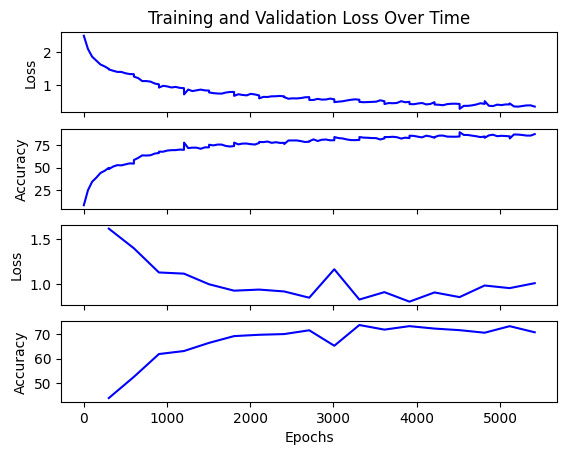

Epoch 19
Batch1, Loss: 0.285, Accuracy: 87.5%
Batch51, Loss: 0.341, Accuracy: 87.0%
Batch101, Loss: 0.352, Accuracy: 86.6%
Batch151, Loss: 0.342, Accuracy: 87.1%
Batch201, Loss: 0.359, Accuracy: 86.4%
Batch251, Loss: 0.406, Accuracy: 84.7%
Batch301, Loss: 0.410, Accuracy: 84.3%
Val Loss: 0.919, Val Accuracy: 73.3%
*****************************************



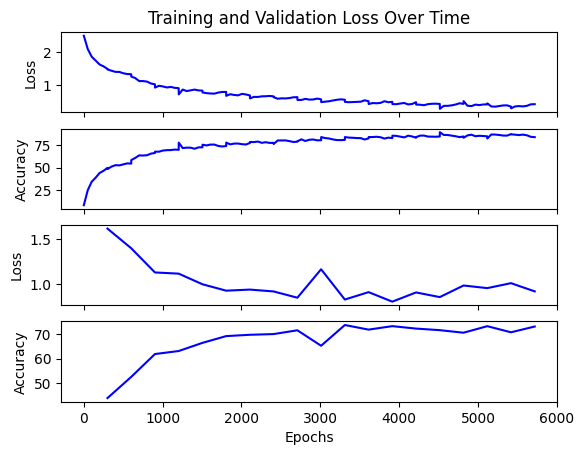

Epoch 20
Batch1, Loss: 0.393, Accuracy: 85.2%
Batch51, Loss: 0.333, Accuracy: 87.2%
Batch101, Loss: 0.348, Accuracy: 86.7%
Batch151, Loss: 0.345, Accuracy: 87.0%
Batch201, Loss: 0.341, Accuracy: 87.0%
Batch251, Loss: 0.340, Accuracy: 87.0%
Batch301, Loss: 0.331, Accuracy: 87.4%
Val Loss: 1.047, Val Accuracy: 74.1%
*****************************************



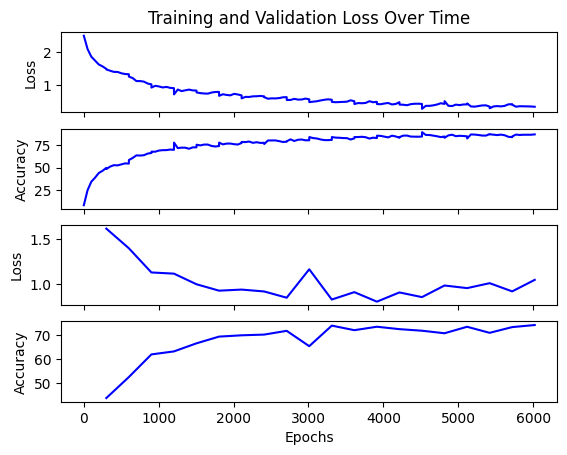

Saved batches_training to Resnet1\batches_training.npy
Saved losses_training to Resnet1\losses_training.npy
Saved accuracies_training to Resnet1\accuracies_training.npy
Saved batches_validation to Resnet1\batches_validation.npy
Saved losses_validation to Resnet1\losses_validation.npy
Saved accuracies_validation to Resnet1\accuracies_validation.npy


In [17]:
#Sets up CNN, optimizer, and loss function
resnet = Resnet()
resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

batches_training = np.array([])
losses_training = np.array([])
accuracies_training  = np.array([])
batches_validation = np.array([])
losses_validation = np.array([])
accuracies_validation = np.array([])

fig = None

#Trains the CNN
num_epochs = 20
for i in range(num_epochs):
    print(f"Epoch {i+1}")
    batches_toadd, losses_toadd, accuracy_toadd = train_epoch(resnet, optimizer, criterion)
    last_batch_num = 0 if len(batches_training) == 0 else batches_training[-1]
    batches_training = np.append(batches_training, (np.array(batches_toadd) + last_batch_num + 1))
    losses_training = np.append(losses_training, losses_toadd)
    accuracies_training = np.append(accuracies_training, accuracy_toadd)

    losses_toadd, accuracy_toadd = validate_epoch(resnet, criterion)
    batches_validation = np.append(batches_validation, batches_training[-1])
    losses_validation = np.append(losses_validation, losses_toadd)
    accuracies_validation = np.append(accuracies_validation, accuracy_toadd)

    #Plot
    if fig:
        plt.close(fig)
    fig = new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation)
    
plt.show()

# Save the loss data so that we can process/graph it later
folder_path = "Resnet1"
os.makedirs(folder_path, exist_ok=True)

to_save = {
    "batches_training": batches_training,
    "losses_training": losses_training,
    "accuracies_training": accuracies_training,
    "batches_validation": batches_validation,
    "losses_validation": losses_validation,
    "accuracies_validation": accuracies_validation
}

for name, array in to_save.items():
    file_path = os.path.join(folder_path, f"{name}.npy")
    np.save(file_path, array)
    print(f"Saved {name} to {file_path}")




In [18]:
#Verifies accuracy on test data set
total_correct = 0
total = 0
resnet.train(False)
for batch_index, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(inputs)
        total_correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        total += len(outputs)
print(f"Accuracy {(total_correct/total) * 100}")

Accuracy 75.15900636025441


In [ ]:
torch.save(resnet, 'DeepResNetParams.pth')

In [ ]:
#Loads previously trained models
with torch.serialization.safe_globals([Resnet]):
    resnet = torch.load('DeepResNetParams.pth', weights_only=False)
resnet.to(device)

In [ ]:
test_iter = iter(testloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label: horse
Guess label: horse


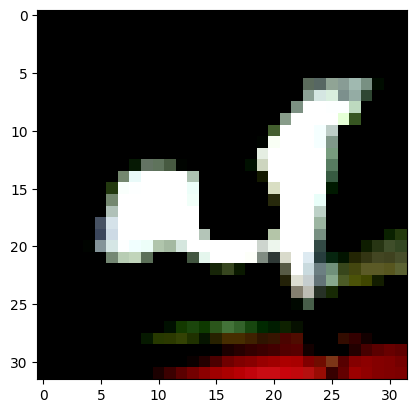

In [32]:
#Shows an image along with a guess and true label
images, true_labels = next(test_iter)
resnet.train(False)
guess_labels = resnet(images.to(device))
np_imgs = images.numpy()
np_img = np_imgs[0]
guess_label = torch.argmax(guess_labels[0]).item()
print(f"True label: {class_names[true_labels[0]]}")
print(f"Guess label: {class_names[guess_label]}")
plt.imshow(np_img.transpose((1, 2, 0)))